In [3]:
from api import inoreader_api, inoreader_scraping
import json
import pandas as pd
import re
import random
import pickle

# Scrape feeds starting from a concrete moment and store them in a file.

In [4]:
start_time = 1508112001
feed = 'user/-/label/arXiv'
file_name = 'articles_raw.json'

number_scraped = inoreader_scraping.scrape(feed, start_time, file_name)
print(number_scraped)


Requesting: stream/contents/user/-/label/arXiv
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=rHZjQ582igTs
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=AzGTbQYwpKpn
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=UfamTHUNYlJQ
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=QDaon65eHcnb
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=M1F3EI0jWJEr
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=U8_DDKnwQFLP
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=1Ip54OMeKfPy
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=z7fm1iiaRfpf
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=FmBgeb1XNcrM
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=uX2Ap5YeTKDk
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=0y_oKEkTduTG
(200, 'OK')

Requesting: stream/contents/user/-/label/arXiv?c=AT6HiC5a960m
(200, 'OK')

Requesting: stream/contents/user/-/labe

# Load the feeds from disk.

In [5]:
f = open(file_name, 'r')
json_string = f.read()
f.close

json_object = json.loads(json_string)
all_articles = json_object['all_articles']

In [6]:
def get_abstract_string(abs_dict):
    abs_string = abs_dict['content']
    abs_string = re.search('<p>(.*)</p>', abs_string, flags=re.DOTALL)
    return abs_string.group(1)

In [7]:
def get_canonical_string(canonical_list):
    url_dict = canonical_list[0]
    url = url_dict['href']
    return url

# Create preprocessed and cleaned DataFrame.

In [8]:
all_articles_pd = pd.DataFrame(all_articles)
all_articles_pd = all_articles_pd[['canonical', 'author', 'categories', 'published', 'title', 'summary']]

for i in range(len(all_articles_pd)):
    all_articles_pd['summary'][i] = get_abstract_string(all_articles_pd['summary'][i])
    all_articles_pd['canonical'][i] = get_canonical_string(all_articles_pd['canonical'][i])
    
all_articles_pd['read'] = False
all_articles_pd['liked'] = False

for i in range(len(all_articles_pd)):
    if 'user/1005689817/state/com.google/read' in all_articles_pd['categories'][i]:
        all_articles_pd['read'][i] = True
    if 'user/1005689817/state/com.google/like' in all_articles_pd['categories'][i]:
        all_articles_pd['liked'][i] = True

del all_articles_pd['categories']

/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:15: 

In [9]:
#all_articles_pd

In [10]:
tagged_articles_pd = all_articles_pd[all_articles_pd['read'] == True]

with open('old_articles_proto2.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    old_tagged_articles_pd = pickle.load(f)
    
tagged_articles_pd = pd.concat([tagged_articles_pd, old_tagged_articles_pd])

In [11]:
tagged_articles_unique_pd = tagged_articles_pd.sort_values(by=['canonical', 'liked'], ascending=False).reset_index(drop=True)
to_drop = tagged_articles_unique_pd.duplicated(subset = ['canonical'], keep='first')
to_drop = list(to_drop[to_drop == False].index.values)

tagged_articles_unique_pd = tagged_articles_unique_pd[tagged_articles_unique_pd.index.isin(to_drop)]

In [12]:
print(len(tagged_articles_pd))
print(len(tagged_articles_unique_pd))

2192
2029


In [13]:
X_ = list(tagged_articles_unique_pd['author']+' '+tagged_articles_unique_pd['title']+' '+tagged_articles_unique_pd['summary'])
y_ = list(tagged_articles_unique_pd['liked'])

In [14]:
index_shuffled = [i for i in range(len(X_))]
random.shuffle(index_shuffled)
X = []
y = []
for i in index_shuffled:
    X.append(X_[i])
    y.append(y_[i])

In [15]:
import keras.preprocessing.text
from string import maketrans

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

Using TensorFlow backend.


In [16]:
with open('stopwords/english') as f:
    stopwords = [line.strip() for line in f]

In [17]:
print(len(X[4]))

for i in range(len(X)):
    seq = text_to_word_sequence(X[i])
    clean_seq = [word for word in seq if word not in stopwords]
    X[i] = ' '.join(clean_seq)
    
print(len(X[4]))

893
683


# SVC

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb_tfidf = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer()),\
    ("nb", BernoulliNB())
])

limit = int(0.8*len(X))

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb_tfidf.fit(X_train, y_train)

y_predicted = model_nb_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/piotr.bednarski/ml-env-27-gpu/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.88669950738916259, 0.93994778067885132)

In [19]:
y_predicted_proba = model_nb_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > 0.15)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*50.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

(0.88669950738916259, 0.93994778067885132, 0, 406)
(0.0, '% - ', 0)


('Rejected good ones: ', 46, '/', 46)
('Accepted wrong ones:', 0, '/', 360)


('Rejected wrong ones: ', 360, '/', 360)
('Accepted good ones:', 0, '/', 46)


array([[  1.00000000e+00,   1.02955817e-27],
       [  1.00000000e+00,   6.30777701e-30],
       [  1.00000000e+00,   5.70110246e-29],
       [  1.00000000e+00,   2.96748834e-25],
       [  1.00000000e+00,   5.44886279e-34],
       [  1.00000000e+00,   1.17075050e-21],
       [  1.00000000e+00,   1.03236179e-25],
       [  1.00000000e+00,   3.38034297e-27],
       [  1.00000000e+00,   4.92712842e-27],
       [  1.00000000e+00,   5.55070573e-30],
       [  1.00000000e+00,   1.64270098e-25],
       [  1.00000000e+00,   3.28509143e-28],
       [  1.00000000e+00,   1.64008798e-23],
       [  1.00000000e+00,   7.77876829e-23],
       [  1.00000000e+00,   2.62401596e-34],
       [  1.00000000e+00,   1.06384566e-22],
       [  1.00000000e+00,   1.02830899e-27],
       [  1.00000000e+00,   2.65577082e-24],
       [  1.00000000e+00,   1.52213930e-28],
       [  1.00000000e+00,   1.54139711e-22]])

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

limit = int(0.8*len(X))

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc.fit(X_train, y_train)

y_predicted = model_svc.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.88177339901477836, 0.88540904309658419)

In [21]:
sum(y_predicted)*100.0/len(y_predicted)

9.8522167487684733

In [22]:
y_predicted_proba = model_svc.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > 0.14)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*50.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

#(0.62077922077922076, 0.55417162908266104, 162, 385)
#(42.077922077922075, '% - ', 21)
#('Rejected good ones: ', 15, '/', 46)
#('Accepted wrong ones:', 131, '/', 339)
#('Rejected wrong ones: ', 208, '/', 339)
#('Accepted good ones:', 31, '/', 46)

(0.66502463054187189, 0.60374231488906716, 164, 406)
(40.39408866995074, '% - ', 20)


('Rejected good ones: ', 9, '/', 46)
('Accepted wrong ones:', 127, '/', 360)


('Rejected wrong ones: ', 233, '/', 360)
('Accepted good ones:', 37, '/', 46)


array([[ 0.83160791,  0.16839209],
       [ 0.90376631,  0.09623369],
       [ 0.70319026,  0.29680974],
       [ 0.84286149,  0.15713851],
       [ 0.94557018,  0.05442982],
       [ 0.81690314,  0.18309686],
       [ 0.79783034,  0.20216966],
       [ 0.83107591,  0.16892409],
       [ 0.89529812,  0.10470188],
       [ 0.83194443,  0.16805557],
       [ 0.89418885,  0.10581115],
       [ 0.928681  ,  0.071319  ],
       [ 0.86478599,  0.13521401],
       [ 0.80600268,  0.19399732],
       [ 0.95882427,  0.04117573],
       [ 0.80979873,  0.19020127],
       [ 0.90021698,  0.09978302],
       [ 0.92225488,  0.07774512],
       [ 0.79529416,  0.20470584],
       [ 0.7356629 ,  0.2643371 ]])

In [23]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional, LSTM, GaussianNoise)
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model #Local

In [24]:
DATASETS_DIR = '../ml-research/datasets/'
GLOVE_DIR = DATASETS_DIR+'glove.6B/'
WIKI_EN_DIR = DATASETS_DIR+'wiki.en/'
#embeddings_file = os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')
embeddings_file = os.path.join(WIKI_EN_DIR, 'wiki.en.vec')

# Word embeddings' constraints
MAX_NB_WORDS = 20000  # Number of most common words for tokenizer
EMBEDDING_DIM = 300   # Embeddings dimensionality

In [25]:
import keras.preprocessing.text
from string import maketrans

def text_to_word_sequence(text,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True, split=" "):
    if lower: text = text.lower()
    if type(text) == unicode:
        translate_table = {ord(c): ord(t) for c,t in zip(filters, split*len(filters)) }
    else:
        translate_table = maketrans(filters, split * len(filters))
    text = text.translate(translate_table)
    seq = text.split(split)
    return [i for i in seq if i]
    
keras.preprocessing.text.text_to_word_sequence = text_to_word_sequence

In [26]:
# Tokenizing and creating word index

additional_words = ['unk', 'num']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X+additional_words)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# inversing the word_index.
index_word = dict((k,v) for v,k in word_index.items())

# example
print(word_index['adversarial'])
print(word_index['unk'])

Found 23177 unique tokens.
87
23176


In [27]:
import models.embedding_matrix as embedding

embedding_matrix = embedding.create_embedding_matrix(embeddings_file, MAX_NB_WORDS, EMBEDDING_DIM, word_index.items())

Indexing word vectors.
Found 2519371 word vectors.
Creating Word Embeddings matrix...
Word Embeddings matrix was successfuly created.


In [28]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional,
                          LSTM, GaussianNoise,Conv1D, MaxPooling1D, Flatten, Dropout)
from keras.optimizers import SGD, RMSprop

from keras.models import Model

In [29]:
hyperparameters = {
    'conv_units': 128,
    'hidden_units_1': 128,
    'hidden_units_2': 64,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.0002,
    'epochs' : 35,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.001,
    'stopwords' : True
}

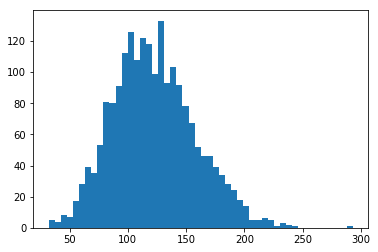

In [30]:
import matplotlib.pyplot as plt

X_sequences = tokenizer.texts_to_sequences(X)
X_sequences_len = []
for item in X_sequences:
    X_sequences_len.append(
                            min( len(item), 1000
                               ))
    
X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

plt.hist(X_sequences_len, 50)
plt.show()

In [31]:
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)

y_num = label_encoder.transform(y)
y_matrix = to_categorical(y_num,hyperparameters['nclasses'])

In [32]:

(len(y)-sum(y))/sum(y)

6

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from keras import backend as K
import utils.evaluation as evaluation
from keras import metrics


class_weight = {0 : 1.,
    1: (len(y)-sum(y))/sum(y)}

acc_list = []
f1_list = []
cm_summed = np.zeros((2,2))
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X_sequences):
    K.clear_session()
    
    X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

    num_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=hyperparameters['max_seq_len'],
                                trainable=False)

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(hyperparameters['max_seq_len'],), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    #x = GaussianNoise(hyperparameters['gauss_stddev'])(embedded_sequences)
    x = embedded_sequences
    x = Conv1D(2*hyperparameters['conv_units'], 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(hyperparameters['conv_units'], 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)

    x = Flatten()(x)
    x = Dense(hyperparameters['hidden_units_1'], activation='relu')(x)
    x = Dropout(hyperparameters['dropout'])(x)
    x = Dense(hyperparameters['hidden_units_2'], activation='relu')(x)
    preds = Dense(hyperparameters['nclasses'], activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.categorical_accuracy])

    
    X_train, X_test = X_sequences_padded[train_index], X_sequences_padded[test_index]
    y_train, y_test = y_matrix[train_index], y_matrix[test_index]

    # train
    model.fit(X_train, y_train,
              batch_size=128,
              epochs=hyperparameters['epochs'],
              class_weight=class_weight,
              validation_data=(X_test, y_test))

    # run
    ground_truth = y_test.argmax(1)
    predictions = [list(map(lambda x: x, model.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
            for x in X_test]
    
    
    acc = evaluation.accuracy(ground_truth, predictions)
    f1 = evaluation.eval_f1_score(ground_truth, predictions)    
    cm = evaluation.cm_matrix(ground_truth, predictions)
    acc_list.append(acc)
    f1_list.append(f1)
    cm_summed = cm_summed + cm
    print(acc, f1)
    print(cm)
    
    #break
    #del model
    #K.clear_session()
    
print(np.asarray(acc).mean(), np.asarray(f1).mean())
print(cm_summed)

Train on 1623 samples, validate on 406 samples
Epoch 1/35
1623/1623 [==============================] - 10s - loss: 1.1574 - categorical_accuracy: 0.6599 - val_loss: 0.6563 - val_categorical_accuracy: 0.8695
Epoch 2/35
1623/1623 [==============================] - 10s - loss: 1.1423 - categorical_accuracy: 0.8632 - val_loss: 0.5935 - val_categorical_accuracy: 0.8695
Epoch 3/35
1623/1623 [==============================] - 10s - loss: 1.1385 - categorical_accuracy: 0.7930 - val_loss: 0.6739 - val_categorical_accuracy: 0.5099
Epoch 4/35
1623/1623 [==============================] - 10s - loss: 1.1194 - categorical_accuracy: 0.6950 - val_loss: 0.5431 - val_categorical_accuracy: 0.8079
Epoch 5/35
1623/1623 [==============================] - 10s - loss: 1.0950 - categorical_accuracy: 0.7012 - val_loss: 0.6159 - val_categorical_accuracy: 0.5813
Epoch 6/35
1623/1623 [==============================] - 10s - loss: 1.0504 - categorical_accuracy: 0.6556 - val_loss: 0.6498 - val_categorical_accuracy: 

1623/1623 [==============================] - 10s - loss: 0.1194 - categorical_accuracy: 0.9710 - val_loss: 1.2183 - val_categorical_accuracy: 0.7734
Epoch 16/35
1623/1623 [==============================] - 10s - loss: 0.0530 - categorical_accuracy: 0.9895 - val_loss: 1.3227 - val_categorical_accuracy: 0.7906
Epoch 17/35
1623/1623 [==============================] - 10s - loss: 0.0314 - categorical_accuracy: 0.9957 - val_loss: 1.4912 - val_categorical_accuracy: 0.7217
Epoch 18/35
1623/1623 [==============================] - 10s - loss: 0.0456 - categorical_accuracy: 0.9883 - val_loss: 1.5546 - val_categorical_accuracy: 0.8153
Epoch 19/35
1623/1623 [==============================] - 10s - loss: 0.0560 - categorical_accuracy: 0.9963 - val_loss: 1.4079 - val_categorical_accuracy: 0.8054
Epoch 20/35
1623/1623 [==============================] - 10s - loss: 0.0238 - categorical_accuracy: 0.9957 - val_loss: 1.4875 - val_categorical_accuracy: 0.8350
Epoch 21/35
1623/1623 [=======================

In [ ]:
ground_truth = y_test.argmax(1)
predictions = [list(map(lambda x: x, model.predict_on_batch(np.asarray([x]))))[0] \
        for x in X_test]

In [ ]:
y_predicted_proba_np = np.asarray(predictions)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.7)

acc = accuracy_score(y_predicted, ground_truth)
f1 = f1_score(y_predicted, ground_truth, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)*100.0/len(y_predicted),"% - ", int(sum(y_predicted)*30.0/len(y_predicted)))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != ground_truth) & (y_predicted == False)]), "/", sum(ground_truth))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != ground_truth) & (y_predicted == True)]), "/", len(ground_truth)-sum(ground_truth))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == ground_truth) & (y_predicted == False)]), "/", len(ground_truth)-sum(ground_truth))
print("Accepted good ones:", len(X_test_df[(y_predicted == ground_truth) & (y_predicted == True)]), "/", sum(ground_truth))

# 15% bezbolesnie odrzucic - 0.000008

# Old stuff

In [ ]:
import numpy as np

# evaluate
y_predicted = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
               for x in x_test]
y_test = y[limit:]
y_test = to_categorical(y_test,2)
y_test = y_test.argmax(1)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted))

X_test_df = pd.DataFrame(X_test)
print("Total good ones:", sum(y_test))
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 0)]))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 1)]))



In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.2)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

In [ ]:

reload(runner)
# Padding sequences
x_train = pad_sequences(sequences_train, maxlen=hyperparameters['max_seq_len'])
x_test = pad_sequences(sequences_test, maxlen=hyperparameters['max_seq_len'])

dataset = x_train, y_train, x_test, y_test, embedding_matrix


In [ ]:

result_cnn, model_cnn = runner.build_train_run(dataset, le, hyperparameters_cnn, save=False, return_model=True)

In [ ]:
# evaluate
import numpy as np
y_predicted = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
               for x in x_test]
y_test = y[limit:]
y_test = to_categorical(y_test,hyperparameters['nclasses'])
y_test = y_test.argmax(1)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted))

X_test_df = pd.DataFrame(X_test)
print("Total good ones:", sum(y_test))
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 0)]))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 1)]))


In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)

#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.0005)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)

y_predicted_proba[0:20]


In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.2)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

In [ ]:
y_test[0:20]